# SSY340 Project - Trajectory Estimation

### Fill in group number and member names:

In [2]:
NAME1 = "Bingcheng Chen" 
NAME2 = "Arvin Rokni"
GROUP = "Project groups 64"

## 1. Loading the data

In [3]:
# importing libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.nn.functional import softmax

import utils
import os
import pandas as pd
import numpy as np
import random
import scipy.spatial
import scipy.io
from copy import deepcopy
import math
from tqdm import tqdm 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import dataloader
import model
import model_Transformer

## 2. Pre-processing

In [4]:
# defining model save location
save_location = "./models"
# defining dataset locations
dataset_folder = "./datasets"
dataset_name = "raw"
# setting validation size. if val_size = 0, split percentage is 80-20
val_size = 0
# lenght of sequence given to encoder
gt = 8
# length of sequence given to decoder
horizon = 12

# creating torch datasets
train_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size, \
    gt, horizon, delim="\t", train=True)
val_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size, \
    gt, horizon, delim="\t", train=False)
# test_dataset, _ = create_dataset(dataset_folder, dataset_name, val_size, \
#     gt, horizon, delim="\t", train=False, eval=True)

# defining batch size
batch_size = 64

# creating torch dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=True, num_workers=0)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers=0)

In [5]:
val_dataset[10]

{'src': tensor([[ 4.9693e+00,  8.3395e+00,  0.0000e+00,  0.0000e+00],
         [ 5.1330e+00,  8.3350e+00,  1.6374e-01, -4.5338e-03],
         [ 5.2968e+00,  8.3307e+00,  1.6374e-01, -4.2963e-03],
         [ 5.3915e+00,  8.3490e+00,  9.4709e-02,  1.8377e-02],
         [ 5.4565e+00,  8.3774e+00,  6.5034e-02,  2.8400e-02],
         [ 5.5218e+00,  8.4058e+00,  6.5244e-02,  2.8400e-02],
         [ 5.5868e+00,  8.4342e+00,  6.5033e-02,  2.8400e-02],
         [ 5.5988e+00,  8.4497e+00,  1.1997e-02,  1.5512e-02]]),
 'trg': tensor([[ 5.5575e+00,  8.4521e+00, -4.1251e-02,  2.3870e-03],
         [ 5.5163e+00,  8.4548e+00, -4.1251e-02,  2.6255e-03],
         [ 5.4750e+00,  8.4571e+00, -4.1251e-02,  2.3861e-03],
         [ 5.4340e+00,  8.4595e+00, -4.1041e-02,  2.3870e-03],
         [ 5.3927e+00,  8.4622e+00, -4.1251e-02,  2.6245e-03],
         [ 5.3515e+00,  8.4645e+00, -4.1251e-02,  2.3870e-03],
         [ 5.3102e+00,  8.4669e+00, -4.1251e-02,  2.3861e-03],
         [ 5.2690e+00,  8.4696e+00, -4.

In [6]:
val_dataset[10]['src'].shape

torch.Size([8, 4])

## 3. Data loaders

## 4. Training

#### 4.1 create a model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tf_model = model_Transformer.Transformer(encoder_input_size=2, decoder_input_size=3,
                                embedding_size=512, num_heads=8, num_layers=6, feedforward_size=2048).to(device)

In [8]:
# tf_model

#### 4.2 The training loop

Value of eta max is: 0.0000


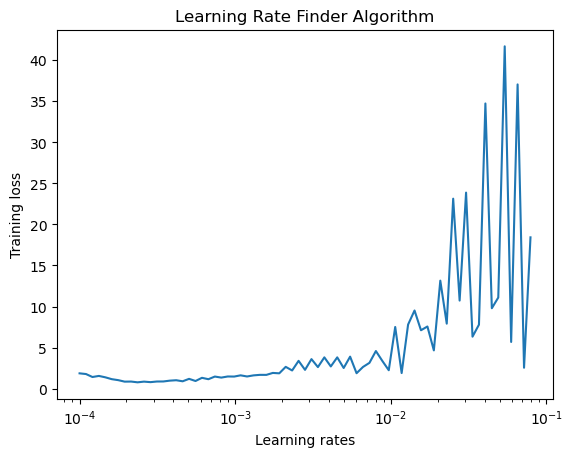

In [9]:
# learning rate finder algorithm for finding eta max

# performing training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating model
# encoder_ip_size = 2
# decoder_ip_size = 3
# model_op_size = 3
# emb_size = 512
# num_heads = 8
# ff_hidden_size = 2048
# n = 6
# dropout=0.1

# tf_model = model.TFModel(encoder_ip_size, decoder_ip_size, model_op_size, emb_size, \
#                 num_heads, ff_hidden_size, n, dropout=0.1).to(device)

# number of iterations for LRF
iterations = 70

# creating optimizer
optimizer = torch.optim.SGD(tf_model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-3, nesterov=True)
# optimizer = torch.optim.Adam(tf_model.parameters(), lr=1e-4)

# calculating the mean and standard deviation of velocities of the entire dataset
mean=torch.cat((train_dataset[:]['src'][:,1:,2:4],train_dataset[:]['trg'][:,:,2:4]),1).mean((0,1))
std=torch.cat((train_dataset[:]['src'][:,1:,2:4],train_dataset[:]['trg'][:,:,2:4]),1).std((0,1))
means=[]
stds=[]
for i in np.unique(train_dataset[:]['dataset']):
    ind=train_dataset[:]['dataset']==i
    means.append(torch.cat((train_dataset[:]['src'][ind, 1:, 2:4], train_dataset[:]['trg'][ind, :, 2:4]), 1).mean((0, 1)))
    stds.append(
        torch.cat((train_dataset[:]['src'][ind, 1:, 2:4], train_dataset[:]['trg'][ind, :, 2:4]), 1).std((0, 1)))
mean=torch.stack(means).mean(0)
std=torch.stack(stds).mean(0)

train_loss, learning_rates = utils.learning_rate_finder(tf_model, optimizer, train_loader, iterations, device, mean, std)
eta_star = learning_rates[np.argmin(np.array(train_loss))]
eta_max = eta_star/10
print("Value of eta max is: {:.4f}".format(eta_max))

# plotting results
plt.figure()
plt.plot(learning_rates, train_loss)
plt.xlabel("Learning rates")
plt.ylabel("Training loss")
plt.xscale('log')
plt.title("Learning Rate Finder Algorithm")
plt.show()

#### 4.3 Train the model

In [11]:
# training loop

# creating model
# encoder_ip_size = 2
# decoder_ip_size = 3
# model_op_size = 3
# emb_size = 512
# num_heads = 8
# ff_hidden_size = 2048
# n = 6
# dropout=0.1

# tf_model = model.TFModel(encoder_ip_size, decoder_ip_size, model_op_size, emb_size, \
#                 num_heads, ff_hidden_size, n, dropout=0.1)
# tf_model = tf_model.to(device)



tf_model = model_Transformer.Transformer(encoder_input_size=2, decoder_input_size=3,
                                embedding_size=512, num_heads=8, num_layers=6, feedforward_size=2048).to(device)

# creating optimizer
optimizer = torch.optim.SGD(tf_model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-3, nesterov=True)
# optimizer = torch.optim.Adam(tf_model.parameters(), lr=1e-4)

# number of epochs 
epochs = 20

# metric variables
training_loss = []
validation_loss = []
val_mad = []
val_fad = []

# finding the total number of weight updates for the network
T = epochs * len(train_loader)
# initializing variable to track the number of weight updates
weight_update = 0
# initializing variable to store the changing learning rate
learning_rate = []

for epoch in tqdm(range(epochs)):
    # TRAINING MODE
    tf_model.train()
    
    # training batch variables
    train_batch_loss = 0

    for idx, data in enumerate(train_loader):
        # changing the learning rate based on cosine scheduler
        lr = utils.cosine_scheduler(weight_update, eta_max, T)
        for param in optimizer.param_groups:
            learning_rate.append(lr)
            param['lr'] = lr
        weight_update += 1

        # getting encoder input data
        enc_input = (data['src'][:,1:,2:4].to(device)-mean.to(device))/std.to(device)

        # getting decoder input data
        target = (data['trg'][:,:-1,2:4].to(device)-mean.to(device))/std.to(device)
        target_append = torch.zeros((target.shape[0],target.shape[1],1)).to(device)
        target = torch.cat((target,target_append),-1)
        start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0],1,1).to(device)
        dec_input = torch.cat((start_of_seq, target), 1)

        # getting masks for decoder
        dec_source_mask = torch.ones((enc_input.shape[0], 1,enc_input.shape[1])).to(device)
        dec_target_mask = utils.subsequent_mask(dec_input.shape[1]).repeat(dec_input.shape[0],1,1).to(device)

        # forward pass 
        optimizer.zero_grad()
        # predictions = tf_model.forward(enc_input, dec_input, dec_source_mask, dec_target_mask)
        predictions = tf_model.forward(enc_input, dec_input)
        

        # calculating loss using pairwise distance of all predictions
        loss = F.pairwise_distance(predictions[:, :,0:2].contiguous().view(-1, 2),
                                    ((data['trg'][:, :, 2:4].to(device)-mean.to(device))/std.to(device)).\
                                    contiguous().view(-1, 2).to(device)).mean() + \
                                    torch.mean(torch.abs(predictions[:,:,2]))
        train_batch_loss += loss.item()
        
        # updating weights
        loss.backward()
        optimizer.step()

    training_loss.append(train_batch_loss/len(train_loader))
    print("Epoch {}/{}....Training loss = {:.4f}".format(epoch+1, epochs, training_loss[-1]))


    # validation loop
    if (epoch+1)%5 == 0:
        with torch.no_grad():
            # EVALUATION MODE
            tf_model.eval()
            
            # validation variables
            batch_val_loss=0
            gt = []
            pr = []

            for id_b, data in enumerate(val_loader):
                # storing groung truth 
                gt.append(data['trg'][:, :, 0:2])

                # input to encoder input
                val_input = (data['src'][:,1:,2:4].to(device)-mean.to(device))/std.to(device)

                # input to decoder
                start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(val_input.shape[0], 1, 1).to(device)
                dec_inp = start_of_seq
                # decoder masks
                dec_source_mask = torch.ones((val_input.shape[0], 1, val_input.shape[1])).to(device)
                dec_target_mask = utils.subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)

                # prediction till horizon lenght
                for i in range(horizon):
                    # getting model prediction
                    # model_output = tf_model.forward(val_input, dec_inp, dec_source_mask, dec_target_mask)
                    model_output = tf_model.forward(val_input, dec_inp)
                    
                    # appending the predicition to decoder input for next cycle
                    dec_inp = torch.cat((dec_inp, model_output[:, -1:, :]), 1)

                # calculating loss using pairwise distance of all predictions
                val_loss = F.pairwise_distance(dec_inp[:,1:,0:2].contiguous().view(-1, 2),
                                        ((data['trg'][:, :, 2:4].to(device)-mean.to(device))/std.to(device)).\
                                            contiguous().view(-1, 2).to(device)).mean() + \
                                            torch.mean(torch.abs(dec_inp[:,1:,2]))
                batch_val_loss += val_loss.item()

                # calculating the position for each time step of prediction based on velocity
                preds_tr_b = (dec_inp[:, 1:, 0:2]*std.to(device) + mean.to(device)).cpu().numpy().cumsum(1) + \
                    data['src'][:,-1:,0:2].cpu().numpy()

                pr.append(preds_tr_b)
            validation_loss.append(batch_val_loss/len(val_loader))

            # calculating mad and fad evaluation metrics
            gt = np.concatenate(gt, 0)
            pr = np.concatenate(pr, 0)
            mad, fad, _ = dataloader.distance_metrics(gt, pr)
            val_mad.append(mad)
            val_fad.append(fad)

            print("Epoch {}/{}....Validation mad = {:.4f}, Validation fad = {:.4f}".format(epoch+1, epochs, mad, fad))

    if (epoch+1)%10 == 0:
        # Saving model, loss and error log files
        torch.save({
            'model_state_dict': tf_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'training_loss': training_loss,
            'validation_loss': validation_loss,
            'val_mad': val_mad,
            'val_fad':val_fad,
            'learning_rate':learning_rate
            }, os.path.join(save_location, 'raw_cosine_sgd_epoch{}.pth'.format(epoch+1)))
    

  5%|██████████▎                                                                                                                                                                                                  | 1/20 [00:34<10:50, 34.25s/it]

Epoch 1/20....Training loss = 0.8915


 10%|████████████████████▌                                                                                                                                                                                        | 2/20 [01:08<10:13, 34.11s/it]

Epoch 2/20....Training loss = 0.6166


 15%|██████████████████████████████▊                                                                                                                                                                              | 3/20 [01:42<09:38, 34.05s/it]

Epoch 3/20....Training loss = 0.5446


 20%|█████████████████████████████████████████                                                                                                                                                                    | 4/20 [02:16<09:04, 34.01s/it]

Epoch 4/20....Training loss = 0.4926
Epoch 5/20....Training loss = 0.4549


 25%|███████████████████████████████████████████████████▎                                                                                                                                                         | 5/20 [03:06<09:56, 39.79s/it]

Epoch 5/20....Validation mad = 0.7973, Validation fad = 1.3046


 30%|█████████████████████████████████████████████████████████████▌                                                                                                                                               | 6/20 [03:40<08:49, 37.80s/it]

Epoch 6/20....Training loss = 0.4293


 35%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 7/20 [04:14<07:54, 36.53s/it]

Epoch 7/20....Training loss = 0.4098


 40%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 8/20 [04:48<07:08, 35.71s/it]

Epoch 8/20....Training loss = 0.3947


 45%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 9/20 [05:21<06:26, 35.15s/it]

Epoch 9/20....Training loss = 0.3825
Epoch 10/20....Training loss = 0.3728
Epoch 10/20....Validation mad = 0.8062, Validation fad = 1.3175


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 11/20 [06:46<05:42, 38.06s/it]

Epoch 11/20....Training loss = 0.3643


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 12/20 [07:20<04:54, 36.81s/it]

Epoch 12/20....Training loss = 0.3574


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 13/20 [07:54<04:11, 35.95s/it]

Epoch 13/20....Training loss = 0.3513


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 14/20 [08:28<03:32, 35.35s/it]

Epoch 14/20....Training loss = 0.3467
Epoch 15/20....Training loss = 0.3425


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 15/20 [09:18<03:18, 39.72s/it]

Epoch 15/20....Validation mad = 0.8189, Validation fad = 1.3439


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 16/20 [09:52<02:31, 37.99s/it]

Epoch 16/20....Training loss = 0.3391


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 17/20 [10:25<01:50, 36.77s/it]

Epoch 17/20....Training loss = 0.3365


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 18/20 [10:59<01:11, 35.92s/it]

Epoch 18/20....Training loss = 0.3346


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 19/20 [11:33<00:35, 35.33s/it]

Epoch 19/20....Training loss = 0.3331
Epoch 20/20....Training loss = 0.3327
Epoch 20/20....Validation mad = 0.8207, Validation fad = 1.3515


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [12:24<00:00, 37.22s/it]


#### 4.4 save the model

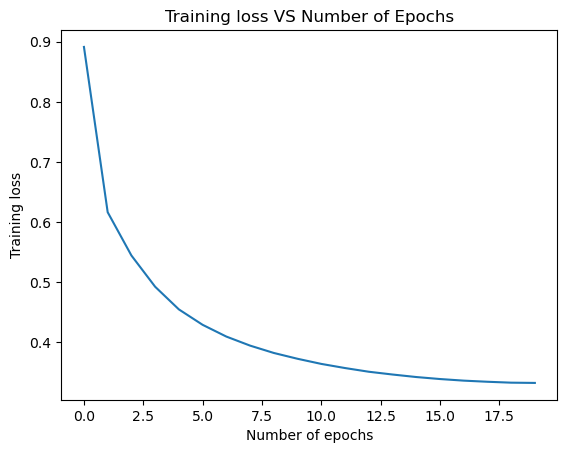

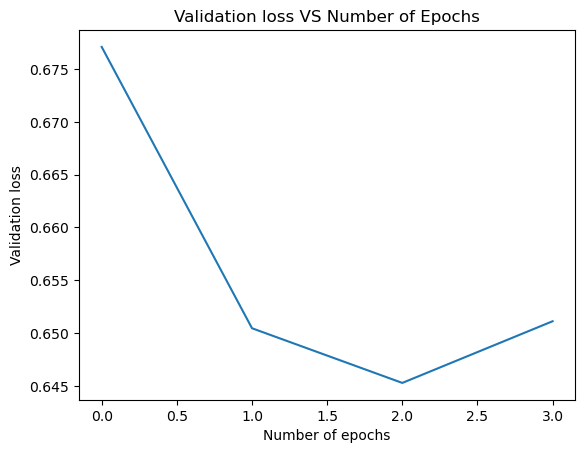

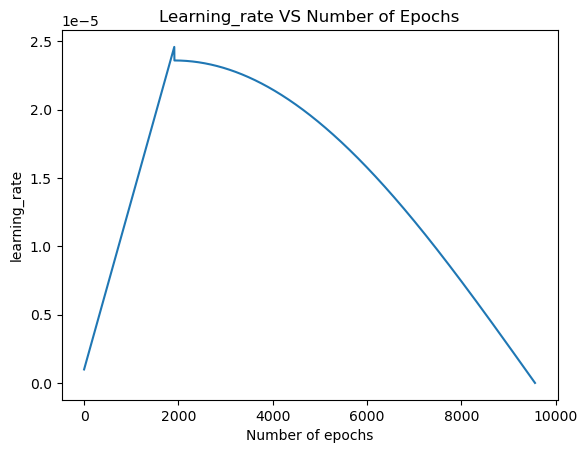

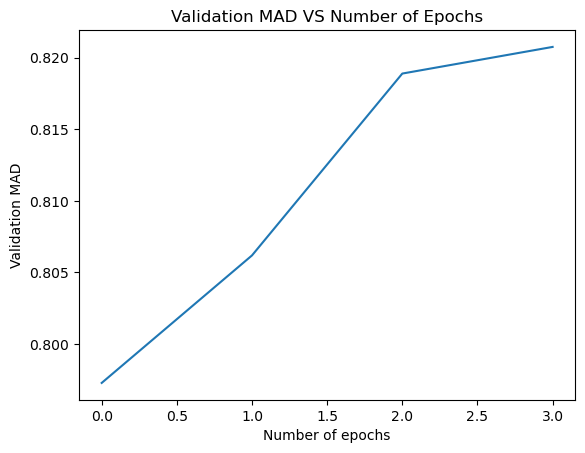

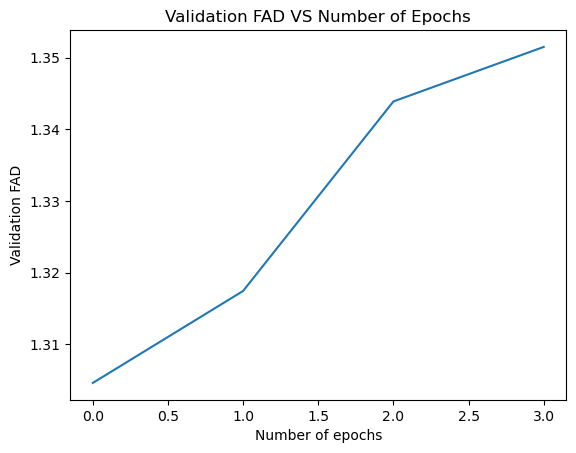

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_file = torch.load(os.path.join(
    save_location, 'raw_cosine_sgd_epoch20.pth'), map_location=torch.device(device))

# creating model and loading weights
# encoder_ip_size = 2
# decoder_ip_size = 3
# model_op_size = 3
# emb_size = 512
# num_heads = 8
# ff_hidden_size = 2048
# n = 6
# dropout = 0.1

# model_loaded = model.TFModel(encoder_ip_size, decoder_ip_size, model_op_size, emb_size,
#                              num_heads, ff_hidden_size, n, dropout=0.1)

model_loaded = model_Transformer.Transformer(encoder_input_size=2, decoder_input_size=3,
                                embedding_size=512, num_heads=8, num_layers=6, feedforward_size=2048)


model_loaded = model_loaded.to(device)
model_loaded.load_state_dict(loaded_file['model_state_dict'])

# loading training metric variables
training_loss = loaded_file['training_loss']
validation_loss = loaded_file['validation_loss']
val_mad = loaded_file['val_mad']
val_fad = loaded_file['val_fad']
learning_rate = loaded_file['learning_rate']

# plotting training loss
plt.figure()
plt.plot(training_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.title("Training loss VS Number of Epochs")

# plotting validation loss
plt.figure()
plt.plot(validation_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Validation loss")
plt.title("Validation loss VS Number of Epochs")

# plotting learning rate for model
plt.figure()
plt.plot(learning_rate)
plt.xlabel("Number of epochs")
plt.ylabel("learning_rate")
plt.title("Learning_rate VS Number of Epochs")

# plotting MAD
plt.figure()
plt.plot(val_mad)
plt.xlabel("Number of epochs")
plt.ylabel("Validation MAD")
plt.title("Validation MAD VS Number of Epochs")

# plotting FAD
plt.figure()
plt.plot(val_fad)
plt.xlabel("Number of epochs")
plt.ylabel("Validation FAD")
plt.title("Validation FAD VS Number of Epochs")

plt.show()

## 5. Visualisation

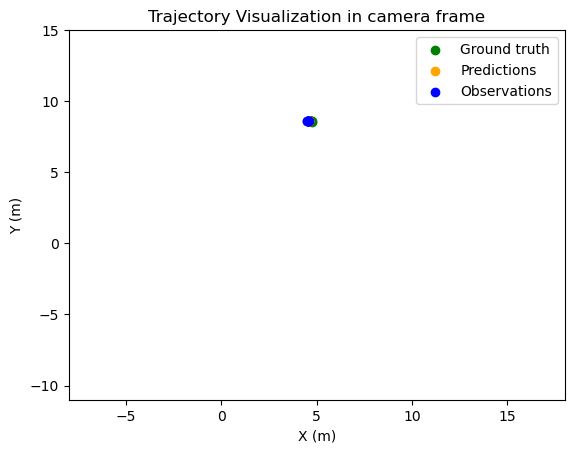

In [13]:
# Running the validation loop to generate prediction trajectories on validation data
validation_loss = []
val_mad = []
val_fad = []

with torch.no_grad():
    # EVALUATION MODE
    model_loaded.eval()

    # validation variables
    batch_val_loss = 0
    gt = []
    pr = []
    obs = []

    for id_b, data in enumerate(val_loader):
        # storing groung truth
        gt.append(data['trg'][:, :, 0:2])
        obs.append(data['src'][:, :, 0:2])
        # input to encoder input
        val_input = (data['src'][:, 1:, 2:4].to(
            device)-mean.to(device))/std.to(device)

        # input to decoder
        start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(
            1).repeat(val_input.shape[0], 1, 1).to(device)
        dec_inp = start_of_seq
        # decoder masks
        dec_source_mask = torch.ones(
            (val_input.shape[0], 1, val_input.shape[1])).to(device)
        dec_target_mask = utils.subsequent_mask(
            dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)

        # prediction till horizon lenght
        for i in range(horizon):
            # getting model prediction
            # model_output = model_loaded.forward(
            #     val_input, dec_inp, dec_source_mask, dec_target_mask)

            model_output = model_loaded.forward(val_input, dec_inp)

            # appending the predicition to decoder input for next cycle
            dec_inp = torch.cat((dec_inp, model_output[:, -1:, :]), 1)

        # calculating loss using pairwise distance of all predictions
        val_loss = F.pairwise_distance(dec_inp[:, 1:, 0:2].contiguous().view(-1, 2),
                                        ((data['trg'][:, :, 2:4].to(device)-mean.to(device))/std.to(device)).
                                        contiguous().view(-1, 2).to(device)).mean() + \
            torch.mean(torch.abs(dec_inp[:, 1:, 2]))
        batch_val_loss += val_loss.item()

        # calculating the position for each time step of prediction based on velocity
        preds_tr_b = (dec_inp[:, 1:, 0:2]*std.to(device) + mean.to(device)).cpu().numpy().cumsum(1) + \
            data['src'][:, -1:, 0:2].cpu().numpy()

        pr.append(preds_tr_b)
        validation_loss.append(batch_val_loss/len(val_loader))

    # calculating mad and fad evaluation metrics
    gt = np.concatenate(gt, 0)
    pr = np.concatenate(pr, 0)
    obs = np.concatenate(obs, 0)
    mad, fad, _ = dataloader.distance_metrics(gt, pr)
    val_mad.append(mad)
    val_fad.append(fad)

# plotting the predicted and ground truth trajectories
idx = np.random.randint(0, gt.shape[0])
plt.figure()
plt.scatter(gt[idx, :, 0], gt[idx, :, 1],
            color='green', label="Ground truth")
plt.scatter(pr[idx, :, 0], pr[idx, :, 1],
            color='orange', label="Predictions")
plt.scatter(obs[idx, :, 0], obs[idx, :, 1],
            color='b', label="Observations")
plt.legend()
plt.xlim(-8, 18)
plt.ylim(-11, 15)
plt.title("Trajectory Visualization in camera frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.savefig("traj_{}".format(idx))

plt.show()

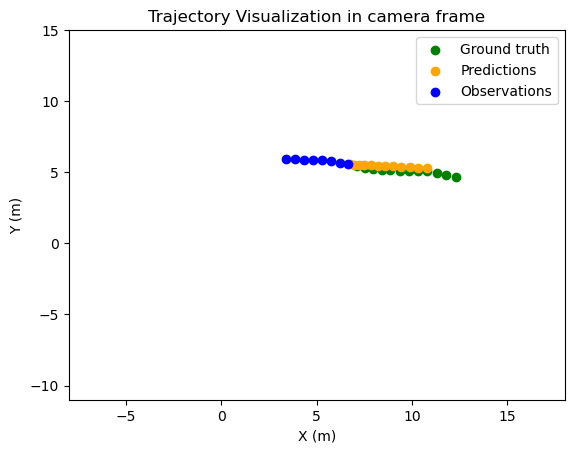

In [20]:
# plotting the predicted and ground truth trajectories
idx = np.random.randint(0, gt.shape[0])
plt.figure()
plt.scatter(gt[idx, :, 0], gt[idx, :, 1],
            color='green', label="Ground truth")
plt.scatter(pr[idx, :, 0], pr[idx, :, 1],
            color='orange', label="Predictions")
plt.scatter(obs[idx, :, 0], obs[idx, :, 1],
            color='b', label="Observations")
plt.legend()
plt.xlim(-8, 18)
plt.ylim(-11, 15)
plt.title("Trajectory Visualization in camera frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
# plt.savefig("traj_{}".format(idx))

plt.show()

## 6. Evaluation on test set